# 1. Neural Networks
## 1.1 Visualizing the data

In [11]:
from scipy.io import loadmat
import scipy.optimize as op

import numpy as np
import matplotlib.pyplot as plt

import math

Loading and Visualizing Data ...


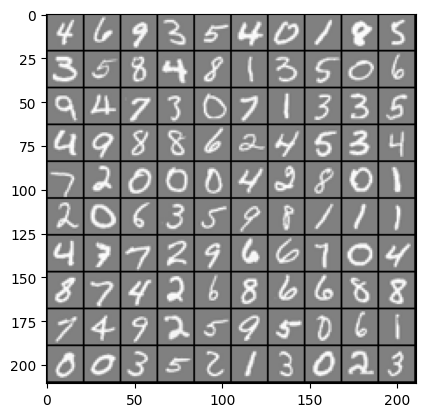

In [12]:
# 获取数据
def displayMNISTImage(x, example_width=None):
    if example_width is None:
        example_width = int(math.sqrt(np.shape(x)[1]))
    example_height = (np.shape(x)[1] // example_width)
    display_rows = math.floor(math.sqrt(np.shape(x)[0]))
    display_cols = math.ceil(np.shape(x)[0] / display_rows)
    pad = 1
    display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))
    curr_ex = 0
    for i in range(display_rows):
        for j in range(display_cols):
            if curr_ex > np.shape(x)[0]:
                break
            max_val = max(abs(x[curr_ex, :]))
            i_layout = pad + i * (example_height + pad)
            j_layout = pad + j * (example_width + pad)
            display_array[i_layout: i_layout + example_height, j_layout: j_layout + example_width] = np.reshape(x[curr_ex], (example_height, example_width)).T / max_val
            curr_ex = curr_ex + 1
        if curr_ex > np.shape(x)[0]:
            break
    plt.imshow(display_array, cmap='gray')
    plt.show()

num_labels = 10
print('Loading and Visualizing Data ...')
# 获取数据
data = loadmat('ex3data1.mat')
x = data['X']
y = data['y'] - 1
# 可视化
rand_indices = np.random.permutation(np.array(range(len(x))))
sel = x[rand_indices[0:100]]
displayMNISTImage(sel)

## 1.2 Model Representation

In [13]:
# 模型预处理
weights = loadmat('ex3weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
all_theta = np.hstack((Theta1.flatten(), Theta2.flatten()))
# m = 5000，X的行数
m = data['X'].shape[0]
# n = 400，X的列数
n = data['X'].shape[1]
# 一次输出的单元数
K = 10
# 对y重新编码
def oneHotEncoder(arr):
    m=arr.shape[0]
    arr_onehot=np.zeros((m,10))
    for i in range(m):
        arr_onehot[i][arr[i]]=1
    return arr_onehot

y=oneHotEncoder(y)

# 2. Backpropagation
## 2.3 Backpropagation
## 2.5 Regularized Neural Network

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

def feedForwProp(Theta1, Theta2, x):
    # 传入的x的维度为 5000x400

    # !m = x.shape[1]
    
    # 添加偏置单元
    m=x.shape[0]
    one=np.ones((m,1))
    # 得到a1，第一次输入
    a1=np.hstack((one,x))
    # 得到z2，第一次输出
    z2=np.dot(a1,Theta1.T)
    # 添加偏置单元
    m=z2.shape[0]
    one=np.ones((m,1))
    # 得到a2,第二次输入
    a2=np.hstack((one,sigmoid(z2)))
    # 得到z3,第二次输出
    z3=np.dot(a2,Theta2.T)
    # 得到a3,第三次输入（最终输出）a3 维度为 5000x10
    a3=sigmoid(z3)
    
    return a3

def nnCostReg(all_theta, x, y, lmd):
    # !m = x.shape[1]
    m = x.shape[0]
    Theta1 = np.reshape(all_theta[0 : 25 * 401], (25, 401))
    Theta2 = np.reshape(all_theta[25 * 401 : ], (10, 26))
    # 得到实际输出a3 a3 维度为 5000x10
    a3=feedForwProp(Theta1, Theta2, x)
    # 损失值
    J=(y*(np.log(a3))+(1-y)*(np.log(1-a3))).sum()*(-1)/m
    # 正则化项
    normal=(np.power(Theta1,2).sum()+np.power(Theta2,2).sum())*lmd/(2*m)
    # 正则化后的损失值
    cost=J+normal
    
    return cost

def nnGradReg(all_theta, x, y, lmd):
    m = x.shape[1]
    n = x.shape[0]

    Theta1 = np.reshape(all_theta[0 : 25 * 401], (25, 401))
    Theta2 = np.reshape(all_theta[25 * 401 : ], (10, 26))
    # 添加偏置单元
    one=np.ones((n,1))
    # 得到a1，第一次输入
    a1=np.hstack((one,x))
    # 得到z2，第一次输出
    z2=np.dot(a1,Theta1.T)
    # 添加偏置单元
    n=z2.shape[0]
    one=np.ones((n,1))
    # 得到a2,第二次输入
    a2=np.hstack((one,sigmoid(z2)))
    # 得到实际输出a3 a3 维度为 5000x10
    a3=feedForwProp(Theta1, Theta2, x)
    # 第3层误差 维度 5000x10
    delta3=a3-y
    # 第2层误差 维度 5000x25 
    delta2=np.dot(delta3,Theta2[:,1:])*sigmoidGradient(z2)
    # 第二层梯度 维度 10x26
    grad2=np.dot(delta3.T,a2)/m
    # 第一层梯度 维度 25x401
    grad1=np.dot(delta2.T,a1)/m
    # 正则化项
    normal2=Theta2[:,1:]*lmd/m
    normal1=Theta1[:,1:]*lmd/m
    # 带正则化项梯度
    grad2[:,1:]=grad2[:,1:]+normal2
    grad1[:,1:]=grad1[:,1:]+normal1

    grad = np.concatenate([grad1.ravel(), grad2.ravel()])

    return grad # grad为一维数组

In [15]:

print('Feedforward Using Neural Network ...')
lmd = 0
J = nnCostReg(all_theta, x, y, lmd)
print('Cost at parameters (loaded from ex4weights): ', J)
print('(this value should be about 0.287629)')

print('Checking Cost Function (with Regularization) ... ')
lmd = 1
J = nnCostReg(all_theta, x, y, lmd)
print('Cost at parameters (loaded from ex4weights): ', J)
print('(this value should be about 0.383770)')

print('Evaluating sigmoid gradient...')
gzGradient = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print('Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]: ', gzGradient)

grad = nnGradReg(all_theta, x, y, 3)


Feedforward Using Neural Network ...
Cost at parameters (loaded from ex4weights):  0.2876291651613189
(this value should be about 0.287629)
Checking Cost Function (with Regularization) ... 
Cost at parameters (loaded from ex4weights):  0.384487796242894
(this value should be about 0.383770)
Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:  [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## 2.2 Random Initializing the Parameters of Networks(Theta1 and Theta2)

In [16]:

def randInitWeights(l_in, l_out):
    epsilon_init = 0.12
    return np.random.rand(l_out, l_in + 1) * 2 * epsilon_init - epsilon_init

print('Initializing Neural Network Parameters ...')
initTheta1 = randInitWeights(400, 25)
initTheta2 = randInitWeights(25, 10)
initNNParams = np.append(initTheta1.ravel(), initTheta2.ravel())
initNNParams = np.append(initTheta1.flatten(), initTheta2.flatten())

Initializing Neural Network Parameters ...


## 2.6 Learning parameters using fmincg

In [17]:
print('Training Neural Network... ')
lmd = 3
rslt = op.fmin_cg(nnCostReg, initNNParams, fprime=nnGradReg, args=(x, y, lmd))
Theta1 = np.reshape(rslt[0 : 401 * 25], (25, 401))
Theta2 = np.reshape(rslt[(401 * 25):], (10, 26))

def predict(Theta1, Theta2, x):
    a3 = feedForwProp(Theta1, Theta2, x)
    return np.argmax(a3, axis = 1)

predRslt = predict(Theta1, Theta2, x)
y_label = (data['y'] - 1).flatten()
acc_rate = (predRslt == y_label).sum() / m
print('Training Set Accuracy: {:.2f}'.format(acc_rate * 100), '%')

Training Neural Network... 
         Current function value: 0.705165
         Iterations: 198
         Function evaluations: 734
         Gradient evaluations: 723
Training Set Accuracy: 96.46 %


d:\Python\Lib\site-packages\scipy\optimize\_optimize.py:1764: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


In [18]:
acc_rate = (predRslt.flatten() == y_label).sum() / m
print(acc_rate)

# 0.9786

0.9646


# 3. Visualizing the hidden layer

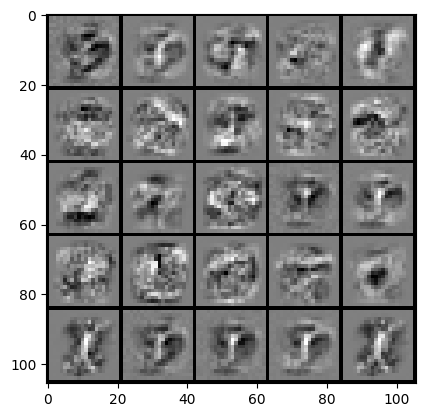

In [19]:
displayMNISTImage(Theta1[:, 1:])